<a href="https://colab.research.google.com/github/Manish927/EDA-Data-Science/blob/feat/census-income/census.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# !pip install ucimlrepo
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from seaborn import countplot
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler

class DatasetWrangler:
    def __init__(self, uci_id, missing_flag='?'):
        """
        Initializes the wrangler by fetching data and flagging missing values.
        """
        print(f"Fetching dataset {uci_id}...")
        dataset = fetch_ucirepo(id=uci_id)

        # Combine X and y into one dataframe
        self.df = pd.concat([dataset.data.features, dataset.data.targets], axis=1)
        self.target_name = dataset.data.targets.columns[0]

        # Immediately set the missing flag to NaN for analysis
        self.df.replace(missing_flag, np.nan, inplace=True)
        print("Data loaded. Missing flags handled.")

    def display_info(self):
        """Displays the structural info of the dataframe (types, memory, etc.)"""
        print("\n--- 📋 Dataframe Information ---")
        self.df.info()
        return self

    def show_missing_stats(self):
        """Calculates and prints the percentage of missing values per column."""
        stats = (self.df.isnull().mean() * 100).round(2)
        stats = stats[stats > 0].sort_values(ascending=False)

        if stats.empty:
            print("No missing values detected!")
        else:
            print("\n--- Missing Value Percentages ---")
            print(stats)
        return self

    def plot_missing_scatterness(self):
        """Generates the Matrix and Heatmap to visualize missing data distribution."""
        print("\nGenerating missingness visualizations...")

        # Matrix Plot (The 'Scatteredness' barcode)
        plt.figure(figsize=(10, 4))
        msno.matrix(self.df)
        plt.title(f"Missing Values Matrix (Dataset ID)", fontsize=16)
        plt.show()

        # Heatmap (The Correlation of missingness)
        if self.df.isnull().sum().sum() > 0:
            plt.figure(figsize=(8, 6))
            msno.heatmap(self.df)
            plt.title("Missingness Correlation Heatmap", fontsize=16)
            plt.show()
        else:
            print("Skipping heatmap: No missing values to correlate.")
        return self

    def get_data(self):
        """Returns the current state of the dataframe."""
        return self.df

    def plot_distributions(self):
        """
        Automatically creates histograms for numerical data
        and count plots for categorical data.
        """
        print("\n📊 Generating distributions for all columns...")

        # Identify column types
        num_cols = self.df.select_dtypes(include=['number']).columns
        cat_cols = self.df.select_dtypes(include=['object', 'category']).columns

        # Plot Numerical Columns (Histograms)
        if len(num_cols) > 0:
            self.df[num_cols].hist(bins=20, figsize=(15, 10), layout=(-1, 3),
                                   edgecolor='black', color='skyblue')
            plt.suptitle("Numerical Feature Distributions (Histograms)", fontsize=20)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

        # Plot Categorical Columns (Bar Charts)
        if len(cat_cols) > 0:
            # We limit to top 10 categories if a column has too many (like 'native-country')
            for col in cat_cols:
                plt.figure(figsize=(10, 4))
                sns.countplot(data=self.df, y=col, order=self.df[col].value_counts().iloc[:10].index, palette='viridis')
                plt.title(f"Top 10 Categories in {col}")
                plt.show()

        return self

    def plot_tsne(self, perplexity=30, n_iter=1000):
        """
        Prepares data and plots a 2D t-SNE visualization colored by the target class.
        """
        print("\n🌀 Preparing t-SNE (this may take a moment for large datasets)...")

        # 1. Create a copy and drop rows with any remaining NaNs
        temp_df = self.df.dropna().copy()

        # 2. Encode categorical columns to numbers
        le = LabelEncoder()
        for col in temp_df.select_dtypes(include=['object']).columns:
            temp_df[col] = le.fit_transform(temp_df[col])

        # 3. Separate Features and Target
        X_vals = temp_df.drop(columns=[self.target_name])
        y_vals = temp_df[self.target_name]

        # 4. Scale the data (Mandatory for t-SNE)
        X_scaled = StandardScaler().fit_transform(X_vals)

        # 5. Run t-SNE
        # For Census data (32k+ rows), we limit to first 5000 rows for speed
        limit = 5000
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        X_embedded = tsne.fit_transform(X_scaled[:limit])
        y_limited = y_vals[:limit]

        # 6. Plot
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1],
                        hue=y_limited, palette='viridis', alpha=0.6)
        plt.title(f"t-SNE Visualization of {self.target_name}", fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
        plt.show()

        return self

Fetching dataset 2...
Data loaded. Missing flags handled.

🌀 Preparing t-SNE (this may take a moment for large datasets)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


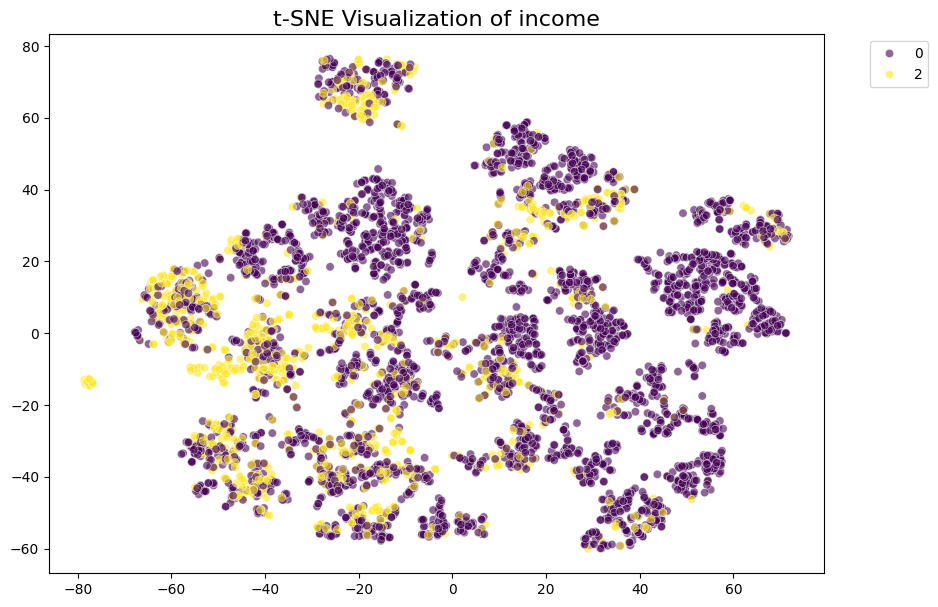

In [56]:
# For Census Income (ID 2), missing values are '?'
census_data = DatasetWrangler(uci_id=2, missing_flag='?')
# Chain the functions to see the stats and plots
#census_data.display_info().show_missing_stats().plot_distributions()
census_data.plot_tsne()

In [ ]:
#display workclass data
census_data.df['native-country'].value_counts()

# Since we need to fill the values in missing columns, we can use iterative imputer, knn(efficient), random forest to predict the missing values.
# to identify outliers, one can use scatter-plot (restricted to 2 variables), IQR(), histogram(), PCA(need to applied after outliers are removed)
# use t-SNE to visualize high dimensional data, in such a way
# in t-SNE an outlier will continue to be an outlier
